# Set Up

In [1]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import usefulFunctions as uf
import numpy as np

In [2]:
#set paths
current_directory = os.getcwd()
base_dir = f'{os.path.dirname(current_directory)}/'
data_dir = f'{base_dir}Source_Data/'
fig_dir = f'{base_dir}figures/'

In [3]:
# set color palettes and variable order
ses_palette = {
    'ses-1': '#440154',
    'ses-2': '#414487', 
    'ses-3': '#2a788e',
    'ses-4': '#22a884',
    'ses-5': '#7ad151'}

dysGroup_palette = {
    'dyslexic': '#8E44AD',
    'typical': '#BB8FCE'}

subGroup_palette = {
    'intervention': '#CD5C5C',
    'dyslexic control': '#D8BFD8',
    'typical control': '#ADD8E6'
}

# set session order
sessions = ['ses-1','ses-2','ses-3','ses-4','ses-5']

# set roi order
rois = ['VWFA1','VWFA2','FFA1','FFA2']

# Define assessment titles
titles = {
    'wj_brs': 'WJ BRS',
    'wj_rf': 'WJ RF',
    'twre_index': 'TOWRE Index',
    'wj_mff_ss': 'WJ MFF'
}


# Baseline Size

## Group Differences

### Figure 2C & Table S1

In [ ]:
# Set to True if you want to save the figure
save_fig = False

#read in data
df_size = pd.read_csv(f'{data_dir}fig_2c.csv')

# ROI labels and legend labels
legend_labels = ['Dyslexic', 'Typical']

# Calculate p-values for significance using t-tests
roi_labels = df_size['roi'].unique()
p_values = []
t_values=[]
DOFs=[]
CIs=[]
avg_sizes=[]
for roi in roi_labels:
    # Get sizes for each ROI and group
    sizes_dyslexic = df_size[(df_size['roi'] == roi) & (df_size['dysGroups'] == 'dyslexic')]['log_size']
    sizes_typical = df_size[(df_size['roi'] == roi) & (df_size['dysGroups'] == 'typical')]['log_size']

    vert_sizes_dyslexic = df_size[(df_size['roi'] == roi) & (df_size['dysGroups'] == 'dyslexic')]['size']
    vert_sizes_typical = df_size[(df_size['roi'] == roi) & (df_size['dysGroups'] == 'typical')]['size']

    if len(sizes_dyslexic) > 1 and len(sizes_typical) > 1:  # Ensure there are enough data points
        results = ttest_ind(sizes_dyslexic, sizes_typical)
        avg_dys = np.mean(vert_sizes_dyslexic)
        avg_typ = np.mean(vert_sizes_typical)
    else:
        p = float('nan')  # No p-value if data is insufficient

    p_values.append(results.pvalue)
    t_values.append(results.statistic)
    DOFs.append(results.df)
    CIs.append(results.confidence_interval())
    avg_sizes.append((avg_dys,avg_typ))

# Plot the data
g = sns.catplot(x='roi', y='log_size', hue='dysGroups', hue_order=['dyslexic', 'typical'],
                data=df_size, kind='box', palette=list(dysGroup_palette.values()),
                height=4, aspect=1.8)
g.set_axis_labels("", "ROI Size\n(log # of vertices)", size=28)
g.set_xticklabels(size=28)
g.set_yticklabels(size=18)

# Add borders to the boxes
for ax in g.axes.flat:
    for box in ax.patches:
        box.set_edgecolor('black')  
        box.set_linewidth(1.5)      

# Remove the original legend
g._legend.remove()

# Add significance indicators
for i, p in enumerate(p_values):
    significance = ''
    if pd.notna(p):
        if p < 0.001:
            significance = '***'
            print(f'{avg_sizes[i]},{t_values[i]},{CIs[i]},{DOFs[i]},{p}')
        elif p < 0.01:
            significance = '**'
            print(f'{avg_sizes[i]},{t_values[i]},{CIs[i]},{DOFs[i]},{p}')
        elif p < 0.05:
            significance = '*'
            print(f'{avg_sizes[i]},{t_values[i]},{CIs[i]},{DOFs[i]},{p}')
        elif p >= 0.05:
            significance = ''
            print(f'{avg_sizes[i]},{t_values[i]},{CIs[i]},{DOFs[i]},{p}')
    if significance:
        # Position the text above the highest box for the given ROI
        y_max = df_size[df_size['roi'] == roi_labels[i]]['log_size'].max()
        if np.isfinite(y_max):  
            ax = g.axes.flat[0]
            ax.text(i, y_max + 0.1, significance, ha='center', va='bottom', fontsize=20, color='black')

# Save the figure
if save_fig:
    plt.savefig(f'{fig_dir}fig_2c.svg', bbox_inches="tight", transparent=True, dpi=400)


### Figure 2d

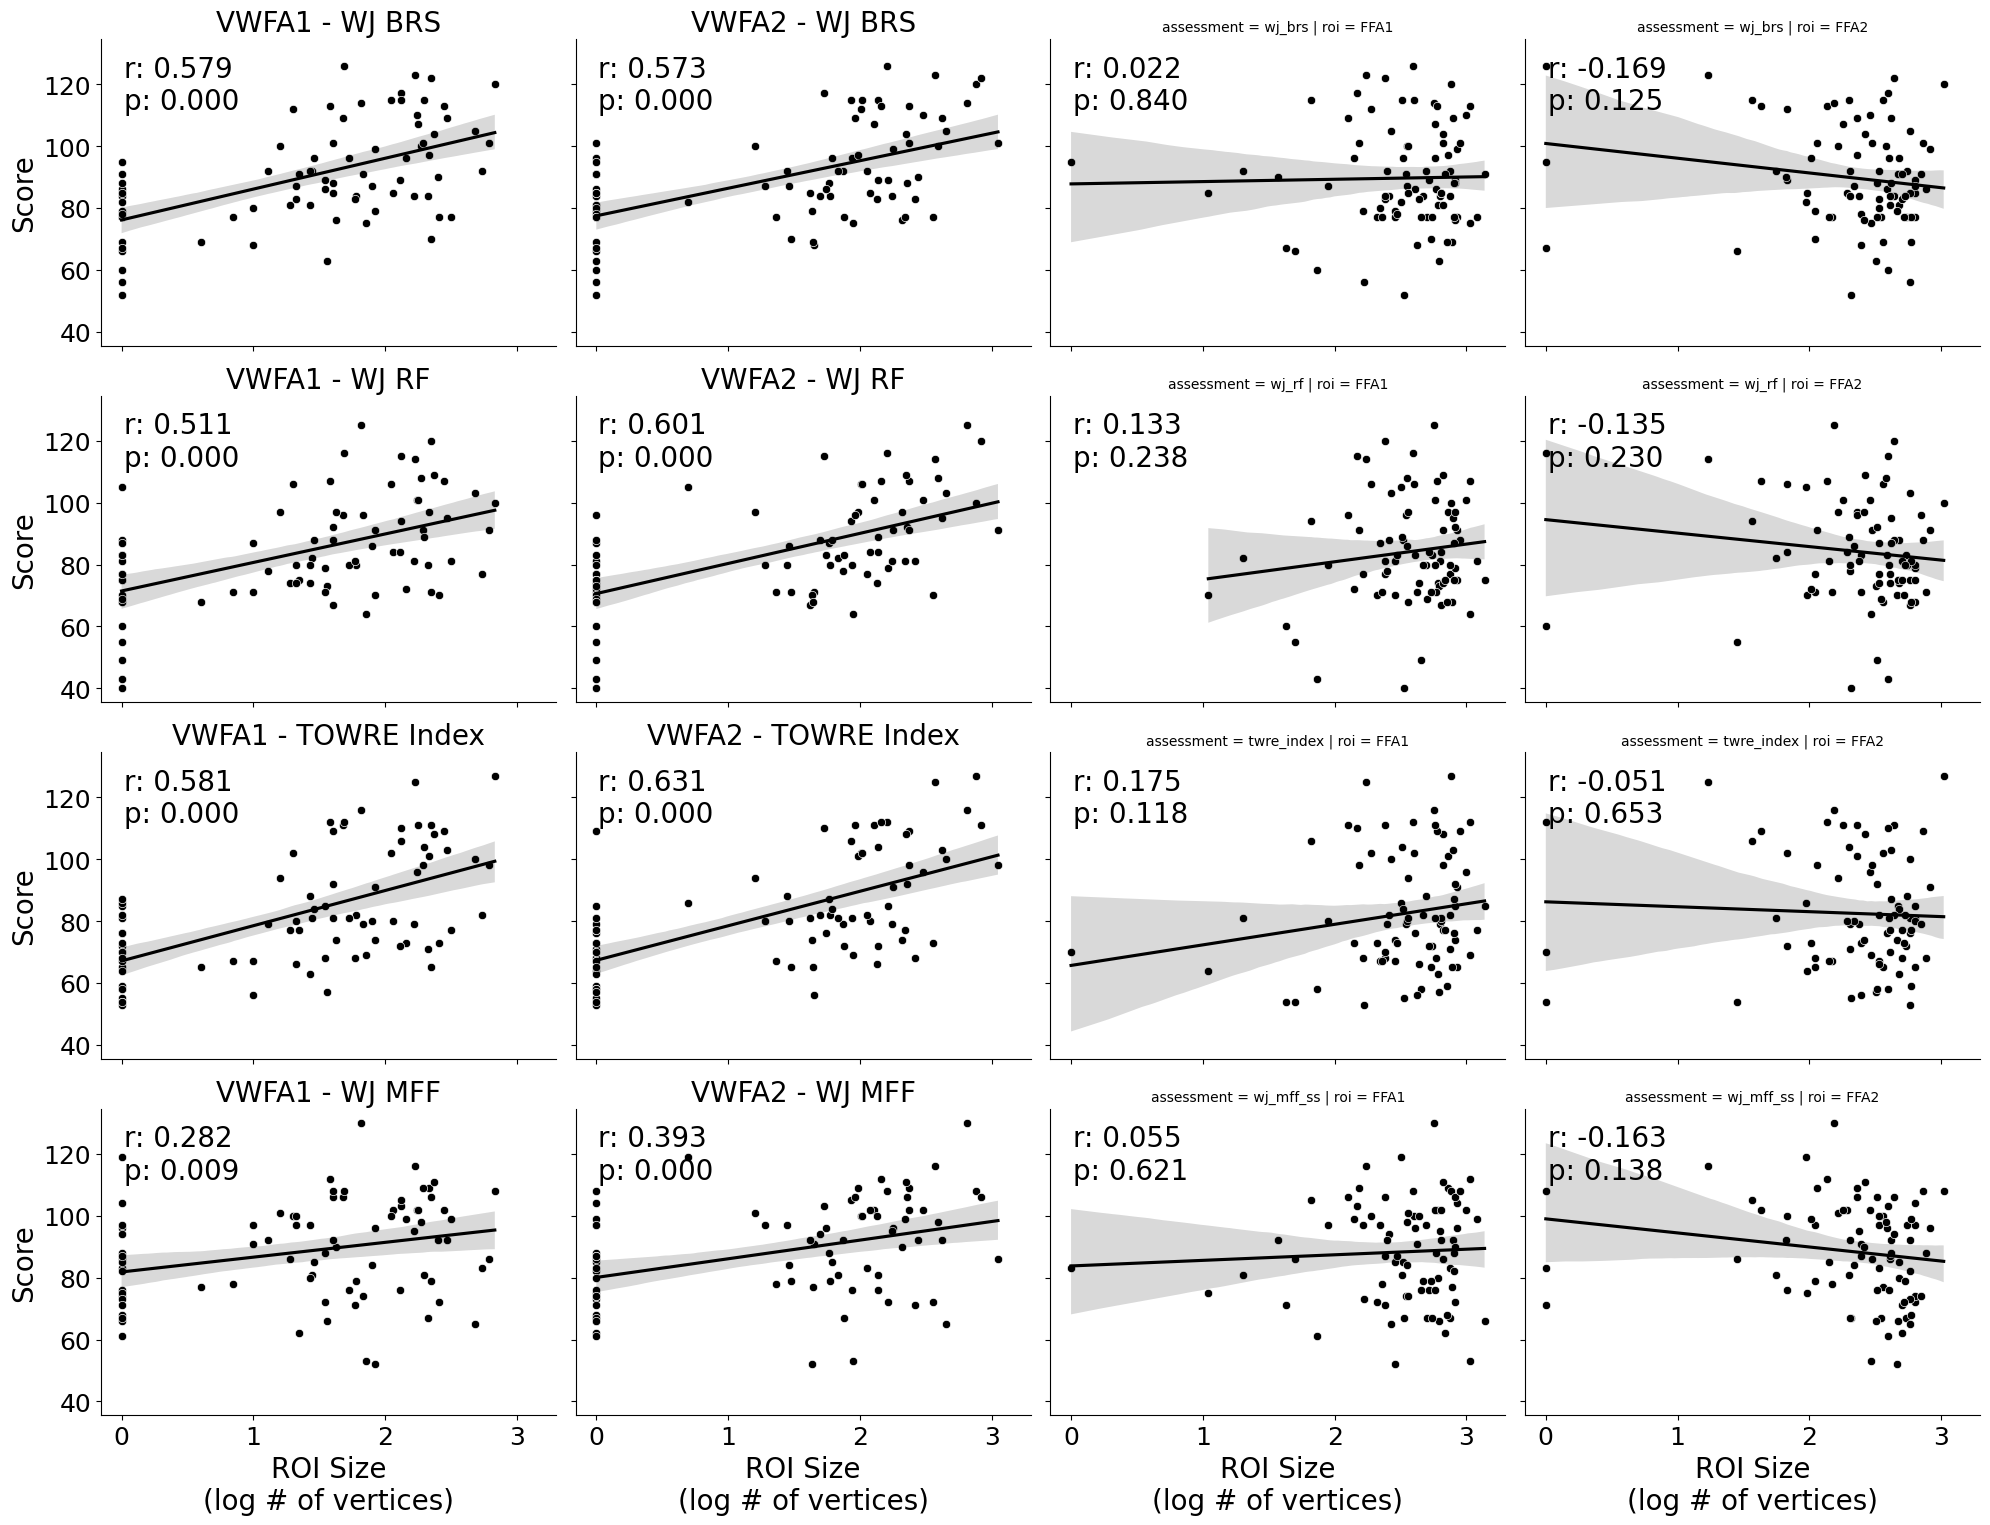

In [11]:
save_fig = False

#load data
df_size = pd.read_csv(f'{data_dir}/fig_2d.csv')

#define assessments
assessments = list(titles.keys())

# Pivot long and create a new column for the assessment
data_long = pd.melt(df_size, id_vars=['sub', 'roi', 'log_size', 'dysGroups'], value_vars=assessments, 
                    var_name='assessment', value_name='score')

# Create a FacetGrid
g = sns.FacetGrid(data_long, row='assessment', col='roi', height=4, aspect=1.25, palette=list(dysGroup_palette.values()))

# Map the scatterplot and regplot onto the FacetGrid
g.map(sns.scatterplot, 'log_size', 'score', color='black')
g.map(sns.regplot, 'log_size', 'score', scatter=False, color='black')

# Apply the annotation function to each subplot
g.map_dataframe(uf.annotate_regression_corr,x_param='log_size',y_param='score')

# Set uniform x and y-axis labels
g.set_axis_labels('ROI Size\n(log # of vertices)', 'Score', size=20)

# Iterate through the axes and set the tick label font size
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=18)

# Set titles and labels for each subplot
for i, roi in enumerate(rois):
    for j, assessment in enumerate(assessments):
        ax = g.axes[j, i]
        ax.set_title(f'{roi} - {titles[assessment]}', size=20)


# Adjust layout to ensure labels are visible
plt.tight_layout(rect=[0, 0, 1, 0.96])

if save_fig:
    g.savefig(f'{fig_dir}fig_2d.svg', bbox_inches="tight", transparent=True, dpi=400)

plt.show()


### Table S3

In [8]:
# load data
df_size = pd.read_csv(f'{data_dir}/tbl_s3.csv')

#define roi variables
rois = np.unique(df_size['roi'])

# loop through rois to calculate correlations
for roi in rois:

    #filter the data
    roi_data = df_size.query('roi==@roi')

    # create mask to filter out nans
    brs_mask = ~np.isnan(roi_data['log_size']) & ~np.isnan(roi_data['wj_brs'])
    rf_mask = ~np.isnan(roi_data['log_size']) & ~np.isnan(roi_data['wj_rf'])
    towre_mask = ~np.isnan(roi_data['log_size']) & ~np.isnan(roi_data['twre_index'])
    mff_mask = ~np.isnan(roi_data['log_size']) & ~np.isnan(roi_data['wj_mff_ss'])
    
    # run stats and store the results
    brs = pearsonr(roi_data['log_size'][brs_mask], roi_data['wj_brs'][brs_mask])
    rf = pearsonr(roi_data['log_size'][rf_mask], roi_data['wj_rf'][rf_mask])
    towre = pearsonr(roi_data['log_size'][towre_mask], roi_data['twre_index'][towre_mask])
    mff = pearsonr(roi_data['log_size'][mff_mask], roi_data['wj_mff_ss'][mff_mask])

    # print results
    print(roi)
    print(f'brs: r={brs.statistic}, CI={brs.confidence_interval()}, DOF={sum(brs_mask)-2}, p={brs.pvalue}')
    print(f'rf: r={rf.statistic}, CI={rf.confidence_interval()}, DOF={sum(rf_mask)-2}, p={rf.pvalue}')
    print(f'towre: r={towre.statistic}, CI={towre.confidence_interval()}, DOF={sum(towre_mask)-2}, p={towre.pvalue}')
    print(f'mff: r={mff.statistic}, CI={mff.confidence_interval()}, DOF={sum(mff_mask)-2}, p={mff.pvalue}')


FFA1
brs: r=0.02236843430999861, CI=ConfidenceInterval(low=-0.19295208636575975, high=0.23563359325305838), DOF=82, p=0.8399452662150745
rf: r=0.1327299797419454, CI=ConfidenceInterval(low=-0.08817486510645672, high=0.3411911483358221), DOF=79, p=0.23750834179602318
towre: r=0.17508446702619296, CI=ConfidenceInterval(low=-0.04498468285177256, high=0.37894688721043956), DOF=79, p=0.11796537790762267
mff: r=0.054723174779015726, CI=ConfidenceInterval(low=-0.1615675816382112, high=0.2659975721611332), DOF=82, p=0.6210224357313897
FFA2
brs: r=-0.16885334367957977, CI=ConfidenceInterval(low=-0.36985912958681944, high=0.047252441522202974), DOF=82, p=0.12467932165693925
rf: r=-0.1347860595903063, CI=ConfidenceInterval(low=-0.34303965027574895, high=0.08609722492031884), DOF=79, p=0.23025453423938877
towre: r=-0.05063440577737194, CI=ConfidenceInterval(low=-0.26604244647287195, high=0.1695899837208564), DOF=79, p=0.6534931295593573
mff: r=-0.16324178236721085, CI=ConfidenceInterval(low=-0.364

## Group Differences without size 0

### Table S2

-3.1821240481824775      ConfidenceInterval(low=-0.6502454203141672, high=-0.14817785318011129)    59.0      0.0023327768879842087
-3.586925961565719      ConfidenceInterval(low=-0.6416262053502066, high=-0.1815303930882966)    54.0      0.0007204506720155394
-0.6443422756778274      ConfidenceInterval(low=-0.26019582544249575, high=0.1328963949381473)    81.0      0.5211740543853979
1.7430658203142186      ConfidenceInterval(low=-0.021988410146689397, high=0.3318482701004637)    79.0      0.08521292857126857


Text(0.5, 1.05, 'ROI Size at Baseline\n(size 0 remove)')

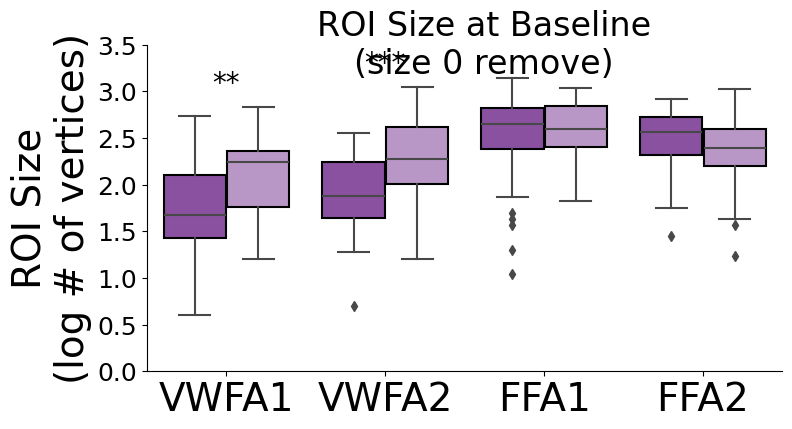

In [6]:
# Set to True if you want to save the figure
save_fig = False

#read in data
df_size = pd.read_csv(f'{data_dir}tbl_s2.csv')

# ROI labels and legend labels
legend_labels = ['Dyslexic', 'Typical']

# Calculate p-values for significance using t-tests
roi_labels = df_size['roi'].unique()
p_values = []
t_values=[]
DOFs=[]
CIs=[]
for roi in roi_labels:
    # Get sizes for each ROI and group
    sizes_dyslexic = df_size[(df_size['roi'] == roi) & (df_size['dysGroups'] == 'dyslexic')]['log_size']
    sizes_typical = df_size[(df_size['roi'] == roi) & (df_size['dysGroups'] == 'typical')]['log_size']
    
    if len(sizes_dyslexic) > 1 and len(sizes_typical) > 1:  # Ensure there are enough data points
        results = ttest_ind(sizes_dyslexic, sizes_typical)
    else:
        p = float('nan')  # No p-value if data is insufficient

    p_values.append(results.pvalue)
    t_values.append(results.statistic)
    DOFs.append(results.df)
    CIs.append(results.confidence_interval())

# Plot the data
g = sns.catplot(x='roi', y='log_size', hue='dysGroups', hue_order=['dyslexic', 'typical'],
                data=df_size, kind='box', palette=list(dysGroup_palette.values()),
                height=4, aspect=1.8)
g.set_axis_labels("", "ROI Size\n(log # of vertices)", size=28)
g.set_xticklabels(size=28)
g.set_yticklabels(size=18)

# Add borders to the boxes
for ax in g.axes.flat:
    for box in ax.patches:
        box.set_edgecolor('black')  
        box.set_linewidth(1.5)      

# Remove the original legend
g._legend.remove()

# Add significance indicators
for i, p in enumerate(p_values):
    significance = ''
    if pd.notna(p):
        if p < 0.001:
            significance = '***'
            print(f'{t_values[i]}      {CIs[i]}    {DOFs[i]}      {p}')
        elif p < 0.01:
            significance = '**'
            print(f'{t_values[i]}      {CIs[i]}    {DOFs[i]}      {p}')
        elif p < 0.05:
            significance = '*'
            print(f'{t_values[i]}      {CIs[i]}    {DOFs[i]}      {p}')
        elif p >= 0.05:
            significance = ''
            print(f'{t_values[i]}      {CIs[i]}    {DOFs[i]}      {p}')
    if significance:
        # Position the text above the highest box for the given ROI
        y_max = df_size[df_size['roi'] == roi_labels[i]]['log_size'].max()
        if np.isfinite(y_max):  
            ax = g.axes.flat[0]
            ax.text(i, y_max + 0.1, significance, ha='center', va='bottom', fontsize=20, color='black')

# Set title of figure
g.fig.suptitle('ROI Size at Baseline\n(size 0 remove)', size=24, y=1.05)



### Figure S1

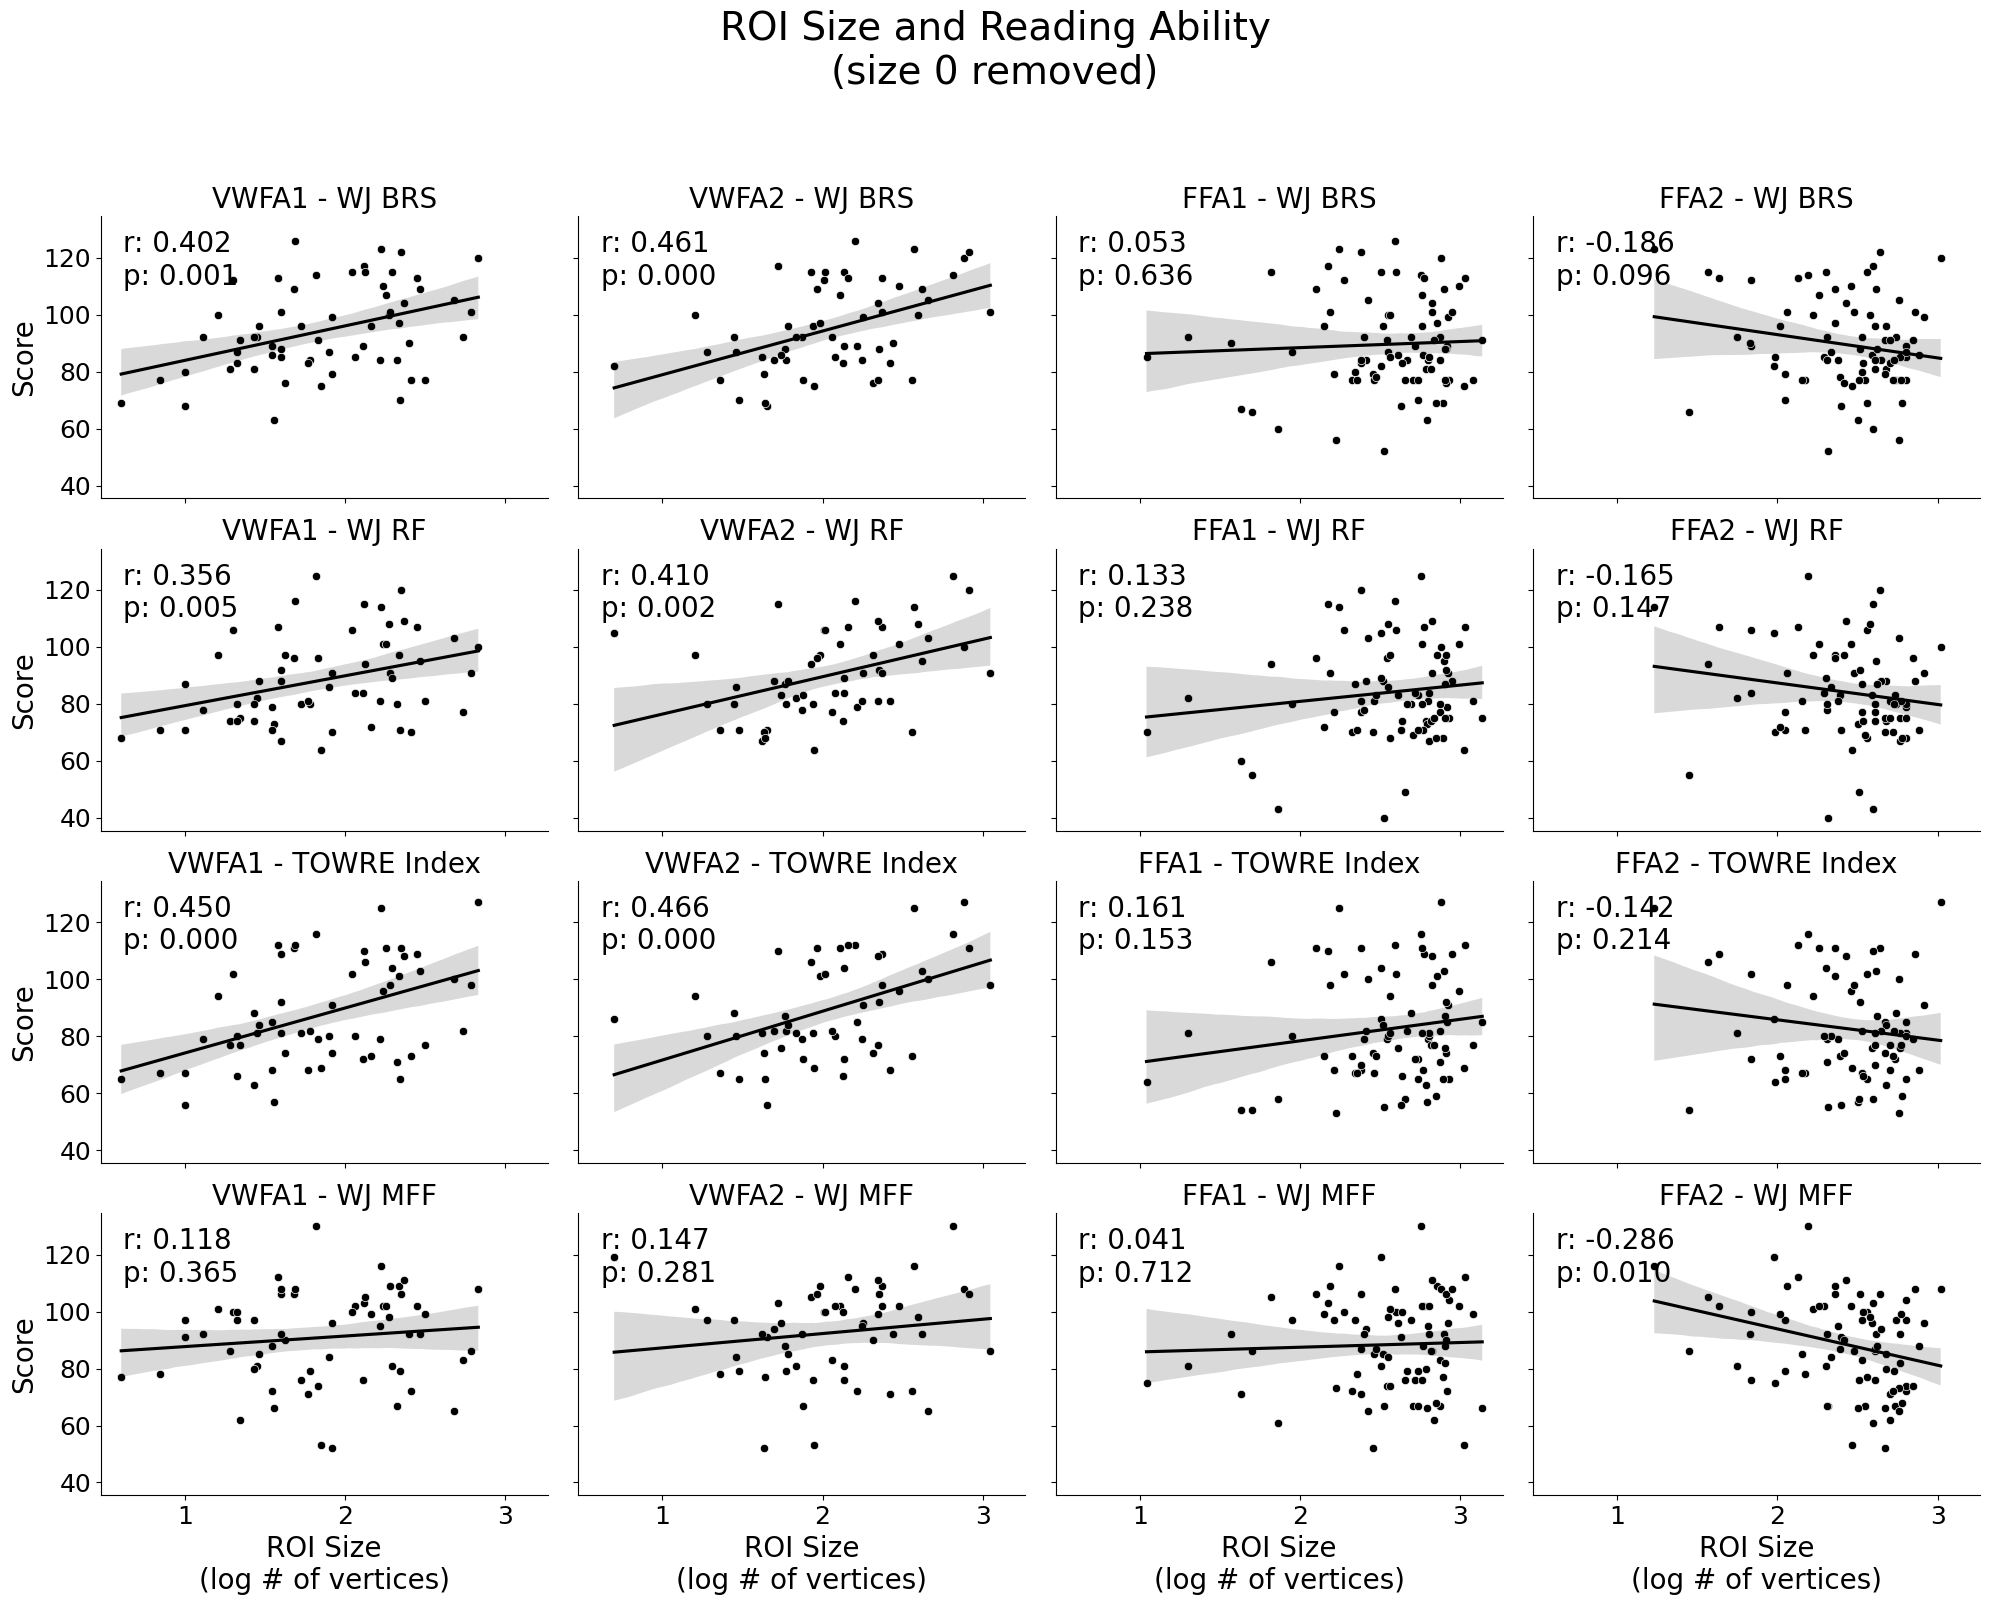

In [11]:
save_fig = False

#load data
df_size = pd.read_csv(f'{data_dir}/fig_s1.csv')

#define variables
assessments = list(titles.keys())
rois = ['VWFA1','VWFA2','FFA1','FFA2']

# Pivot long and create a new column for the assessment
data_long = pd.melt(df_size, id_vars=['sub', 'roi', 'log_size', 'dysGroups'], value_vars=assessments, 
                    var_name='assessment', value_name='score')

# Create a FacetGrid
g = sns.FacetGrid(data_long, row='assessment', col='roi', height=4, aspect=1.25, palette=list(dysGroup_palette.values()))

# Map the scatterplot and regplot onto the FacetGrid
g.map(sns.scatterplot, 'log_size', 'score', color='black')
g.map(sns.regplot, 'log_size', 'score', scatter=False, color='black')

# Apply the annotation function to each subplot
g.map_dataframe(uf.annotate_regression_corr,x_param='log_size',y_param='score')

# Set uniform x and y-axis labels
g.set_axis_labels('ROI Size\n(log # of vertices)', 'Score', size=20)

# Iterate through the axes and set the tick label font size
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=18)

# Set titles and labels for each subplot
for i, roi in enumerate(rois):
    for j, assessment in enumerate(assessments):
        ax = g.axes[j, i]
        ax.set_title(f'{roi} - {titles[assessment]}', size=20)

# Set figure title
g.fig.suptitle('ROI Size and Reading Ability\n(size 0 removed)', size=28, y=1)

# Adjust layout to ensure labels are visible
plt.tight_layout(rect=[0, 0, 1, 0.96])

if save_fig:
    g.savefig(f'{fig_dir}fig_s1.svg', bbox_inches="tight", transparent=True, dpi=400)

plt.show()


# Longitudinal Size
### Figure 3c

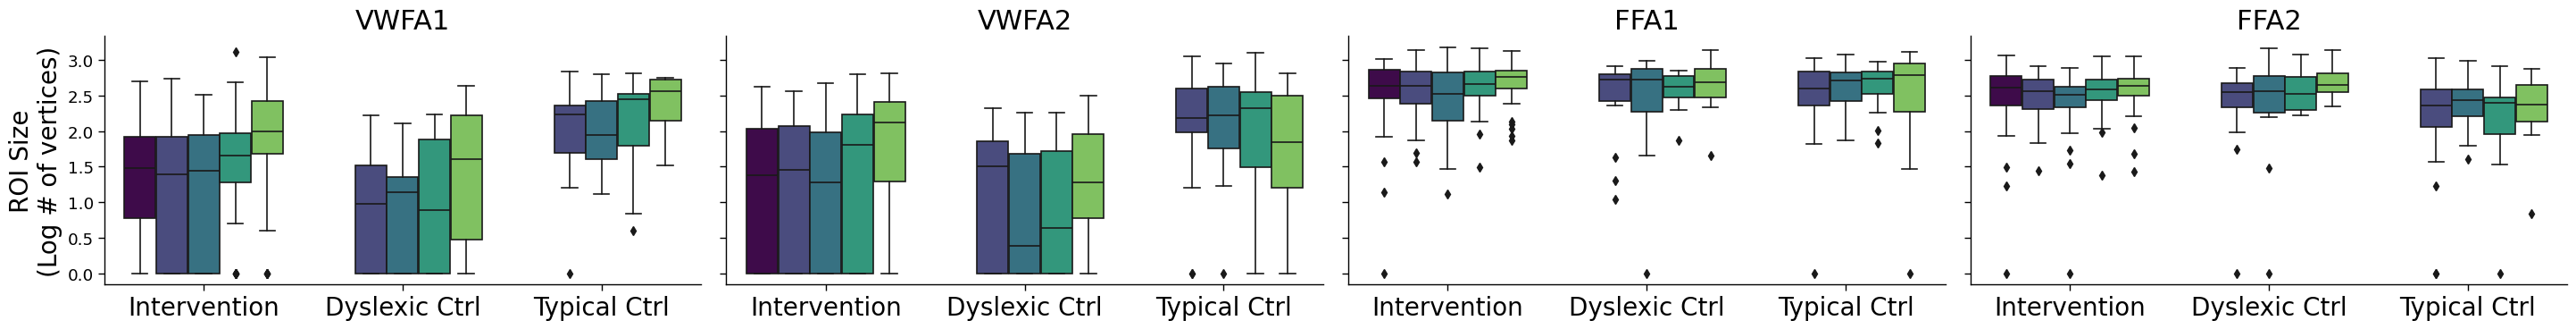

In [8]:
save_fig=False

#load data
size_data = pd.read_csv(f'{data_dir}fig_3c.csv')

#set theme
sns.set_theme(context='paper', style=None, font_scale=1.5)

#plot
g=sns.catplot(x = 'study_group', y = 'log_size', col = 'roi', order=['intervention','dys_control','typ_control'],
            hue = 'ses', hue_order=sessions,
            data = size_data, kind='box',palette=list(ses_palette.values()),
              height=4, aspect=1.8)
g.set_axis_labels("", "ROI Size\n(Log # of vertices)",size=20)
g.set_xticklabels(["Intervention", "Dyslexic Ctrl", "Typical Ctrl"],size=20)
g.set_titles("{col_name}",size=22)

g._legend.remove()

if save_fig:
     plt.savefig(f'{fig_dir}fig_3c.svg', format='svg', bbox_inches="tight",transparent=True, dpi=400)

### Figure S2

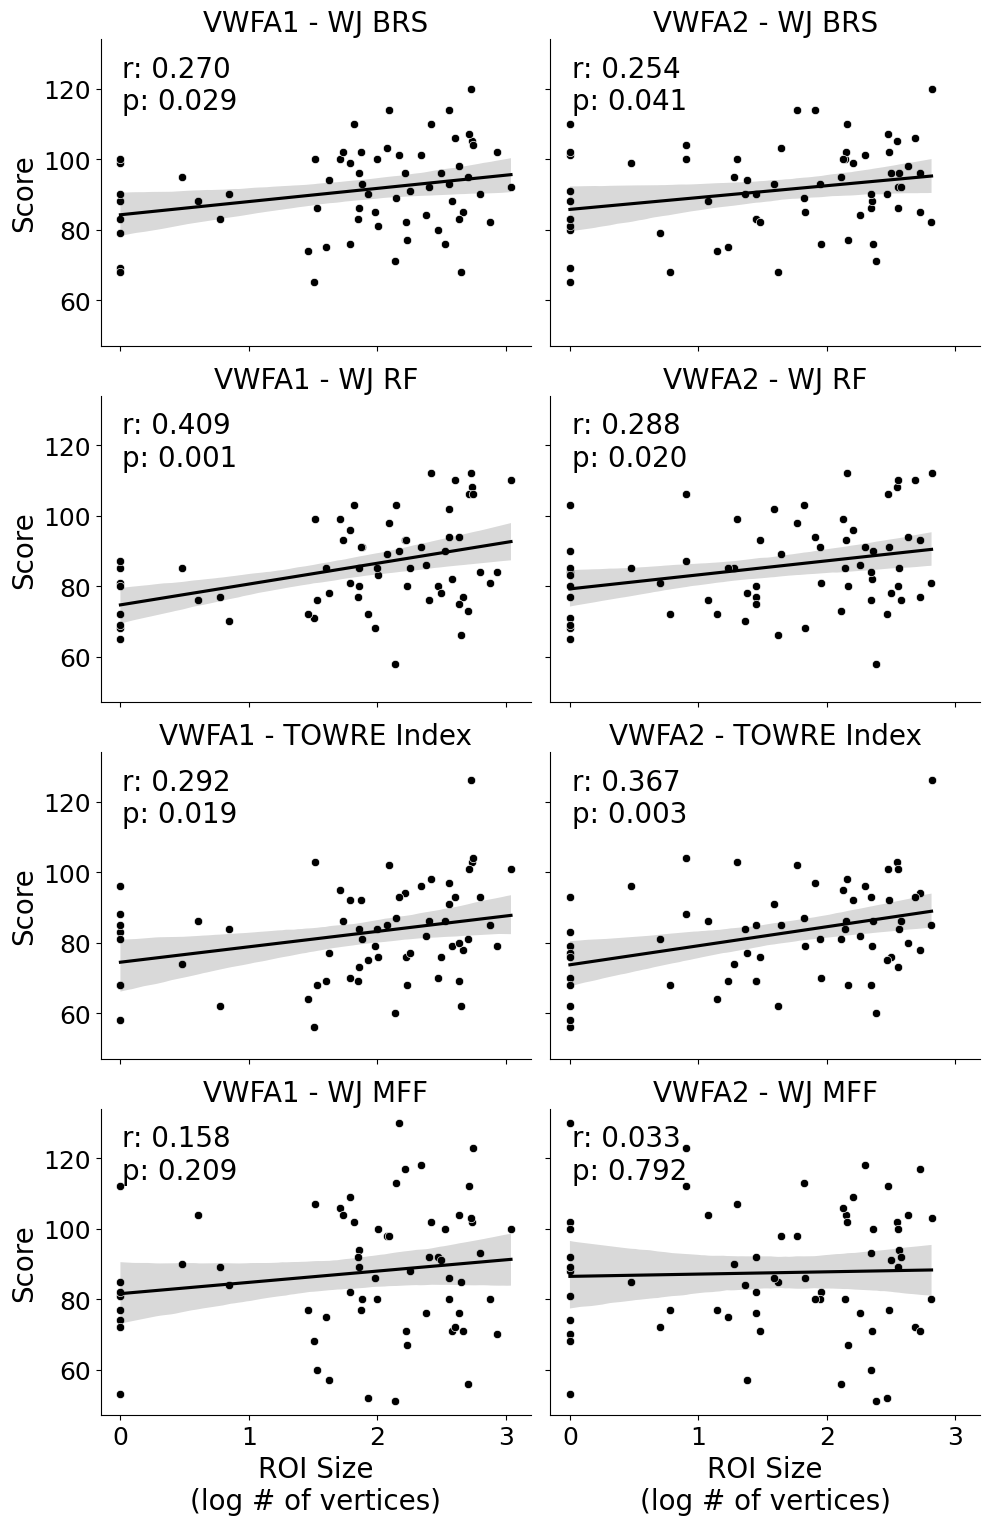

In [16]:
save_fig = False

#load data
df_size = pd.read_csv(f'{data_dir}/fig_s2.csv')

#define assessments
assessments = list(titles.keys())

# Pivot long and create a new column for the assessment
data_long = pd.melt(df_size, id_vars=['sub', 'roi', 'log_size', 'study_group'], value_vars=assessments, 
                    var_name='assessment', value_name='score')

# Create a FacetGrid
g = sns.FacetGrid(data_long, row='assessment', col='roi', height=4, aspect=1.25, palette=list(dysGroup_palette.values()))

# Map the scatterplot and regplot onto the FacetGrid
g.map(sns.scatterplot, 'log_size', 'score', color='black')
g.map(sns.regplot, 'log_size', 'score', scatter=False, color='black')

# Apply the annotation function to each subplot
g.map_dataframe(uf.annotate_regression_corr,x_param='log_size',y_param='score')

# Set uniform x and y-axis labels
g.set_axis_labels('ROI Size\n(log # of vertices)', 'Score', size=20)

# Iterate through the axes and set the tick label font size
for ax in g.axes.flat:
    ax.tick_params(axis='both', labelsize=18)

# Set titles and labels for each subplot
for i, roi in enumerate(rois):
    for j, assessment in enumerate(assessments):
        ax = g.axes[j, i]
        ax.set_title(f'{roi} - {titles[assessment]}', size=20)


# Adjust layout to ensure labels are visible
plt.tight_layout(rect=[0, 0, 1, 0.96])

if save_fig:
    g.savefig(f'{fig_dir}fig_s2.svg', bbox_inches="tight", transparent=True, dpi=400)

plt.show()


### Table S10

In [9]:
#load data
df = pd.read_csv(f'{data_dir}tbl_s10.csv')

# Store results
results = []

# Loop through each roi and session
for roi in df['roi'].unique():
    for session in df['ses'].unique():
        # Filter the DataFrame for the current roi and session
        subset = df[(df['roi'] == roi) & (df['ses'] == session)]
        
        # Get the log sizes for each group
        intervention_log_sizes = subset[subset['study_group'] == 'intervention']['log_size']
        typ_control_log_sizes = subset[subset['study_group'] == 'typ_control']['log_size']
        
        count_intervention = intervention_log_sizes.count()
        count_typ_control = typ_control_log_sizes.count()

        # Calculate t-test only if both groups have data
        if count_intervention > 0 and count_typ_control > 0:
            t_stat, p_value = ttest_ind(intervention_log_sizes, typ_control_log_sizes, equal_var=False)  # Welch's t-test
        else:
            t_stat, p_value = None, None  # Not enough data for comparison
        
        # Append results
        results.append({
            'roi': roi,
            'session': session,
            'count_intervention': count_intervention,
            'count_typ_control': count_typ_control,
            't_stat': t_stat,
            'p_value': p_value
        })

# Create a results DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

      roi session  count_intervention  count_typ_control    t_stat   p_value
0   VWFA1   ses-4                  42                 15 -2.551291  0.016373
1   VWFA1   ses-3                  29                 22 -3.855824  0.000368
2   VWFA1   ses-2                  42                 24 -4.386982  0.000044
3   VWFA1   ses-5                  40                 12 -3.037047  0.004125
4   VWFA2   ses-4                  42                 15 -2.416216  0.021606
5   VWFA2   ses-3                  29                 22 -4.188325  0.000117
6   VWFA2   ses-2                  42                 24 -4.599845  0.000023
7   VWFA2   ses-5                  40                 12  0.106346  0.916524
8    FFA1   ses-4                  42                 15  0.046043  0.963674
9    FFA1   ses-3                  29                 22 -1.491876  0.142206
10   FFA1   ses-2                  42                 24  0.540861  0.592306
11   FFA1   ses-5                  40                 12  0.979330  0.347151

# Threshold Variable Longitudinal Size

### Figure 4

/Users/jamiel12/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jamiel12/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


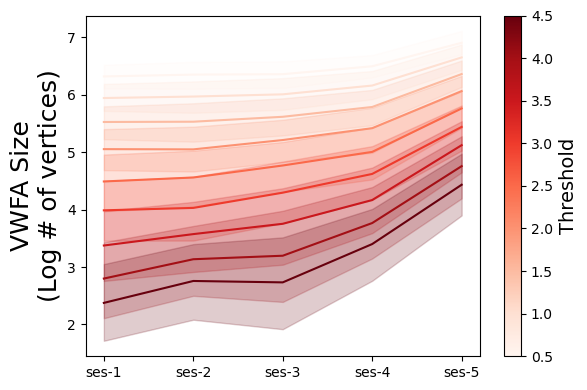

In [56]:
save_fig = False

# load data
thresh_data = pd.read_csv(f'{data_dir}fig_4.csv')

# Convert 'ses' to categorical and specify order
thresh_data['ses'] = pd.Categorical(thresh_data['ses'], categories=['ses-1', 'ses-2', 'ses-3','ses-4','ses-5'], ordered=True)

# Parameters
font_color = 'black'
title_fontsize = 20
axis_fontsize = 18

# Create plot
fig, ax = plt.subplots(figsize=(6, 4))
norm = plt.Normalize(thresh_data['threshold'].min(), thresh_data['threshold'].max())

# Plot lines with continuous color mapping
sns.lineplot(x='ses', y='log_size', hue='threshold', palette='Reds', 
             data=thresh_data, ax=ax, legend=False)

# Title and labels
plt.ylabel('VWFA Size\n(Log # of vertices)', fontsize=axis_fontsize, color=font_color)
plt.xlabel('', fontsize=axis_fontsize, color=font_color)

# Customize ticks
ax.tick_params(axis='x', colors=font_color)
ax.tick_params(axis='y', colors=font_color)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Threshold', fontsize=14, color=font_color)
cbar.ax.yaxis.set_tick_params(color=font_color)
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=font_color)

# Layout adjustments
plt.tight_layout()

# Save figure if needed
if save_fig:
    plt.savefig(f'{fig_dir}fig_4.svg', bbox_inches="tight",transparent=True, dpi=400)

plt.show()


### Figure s3

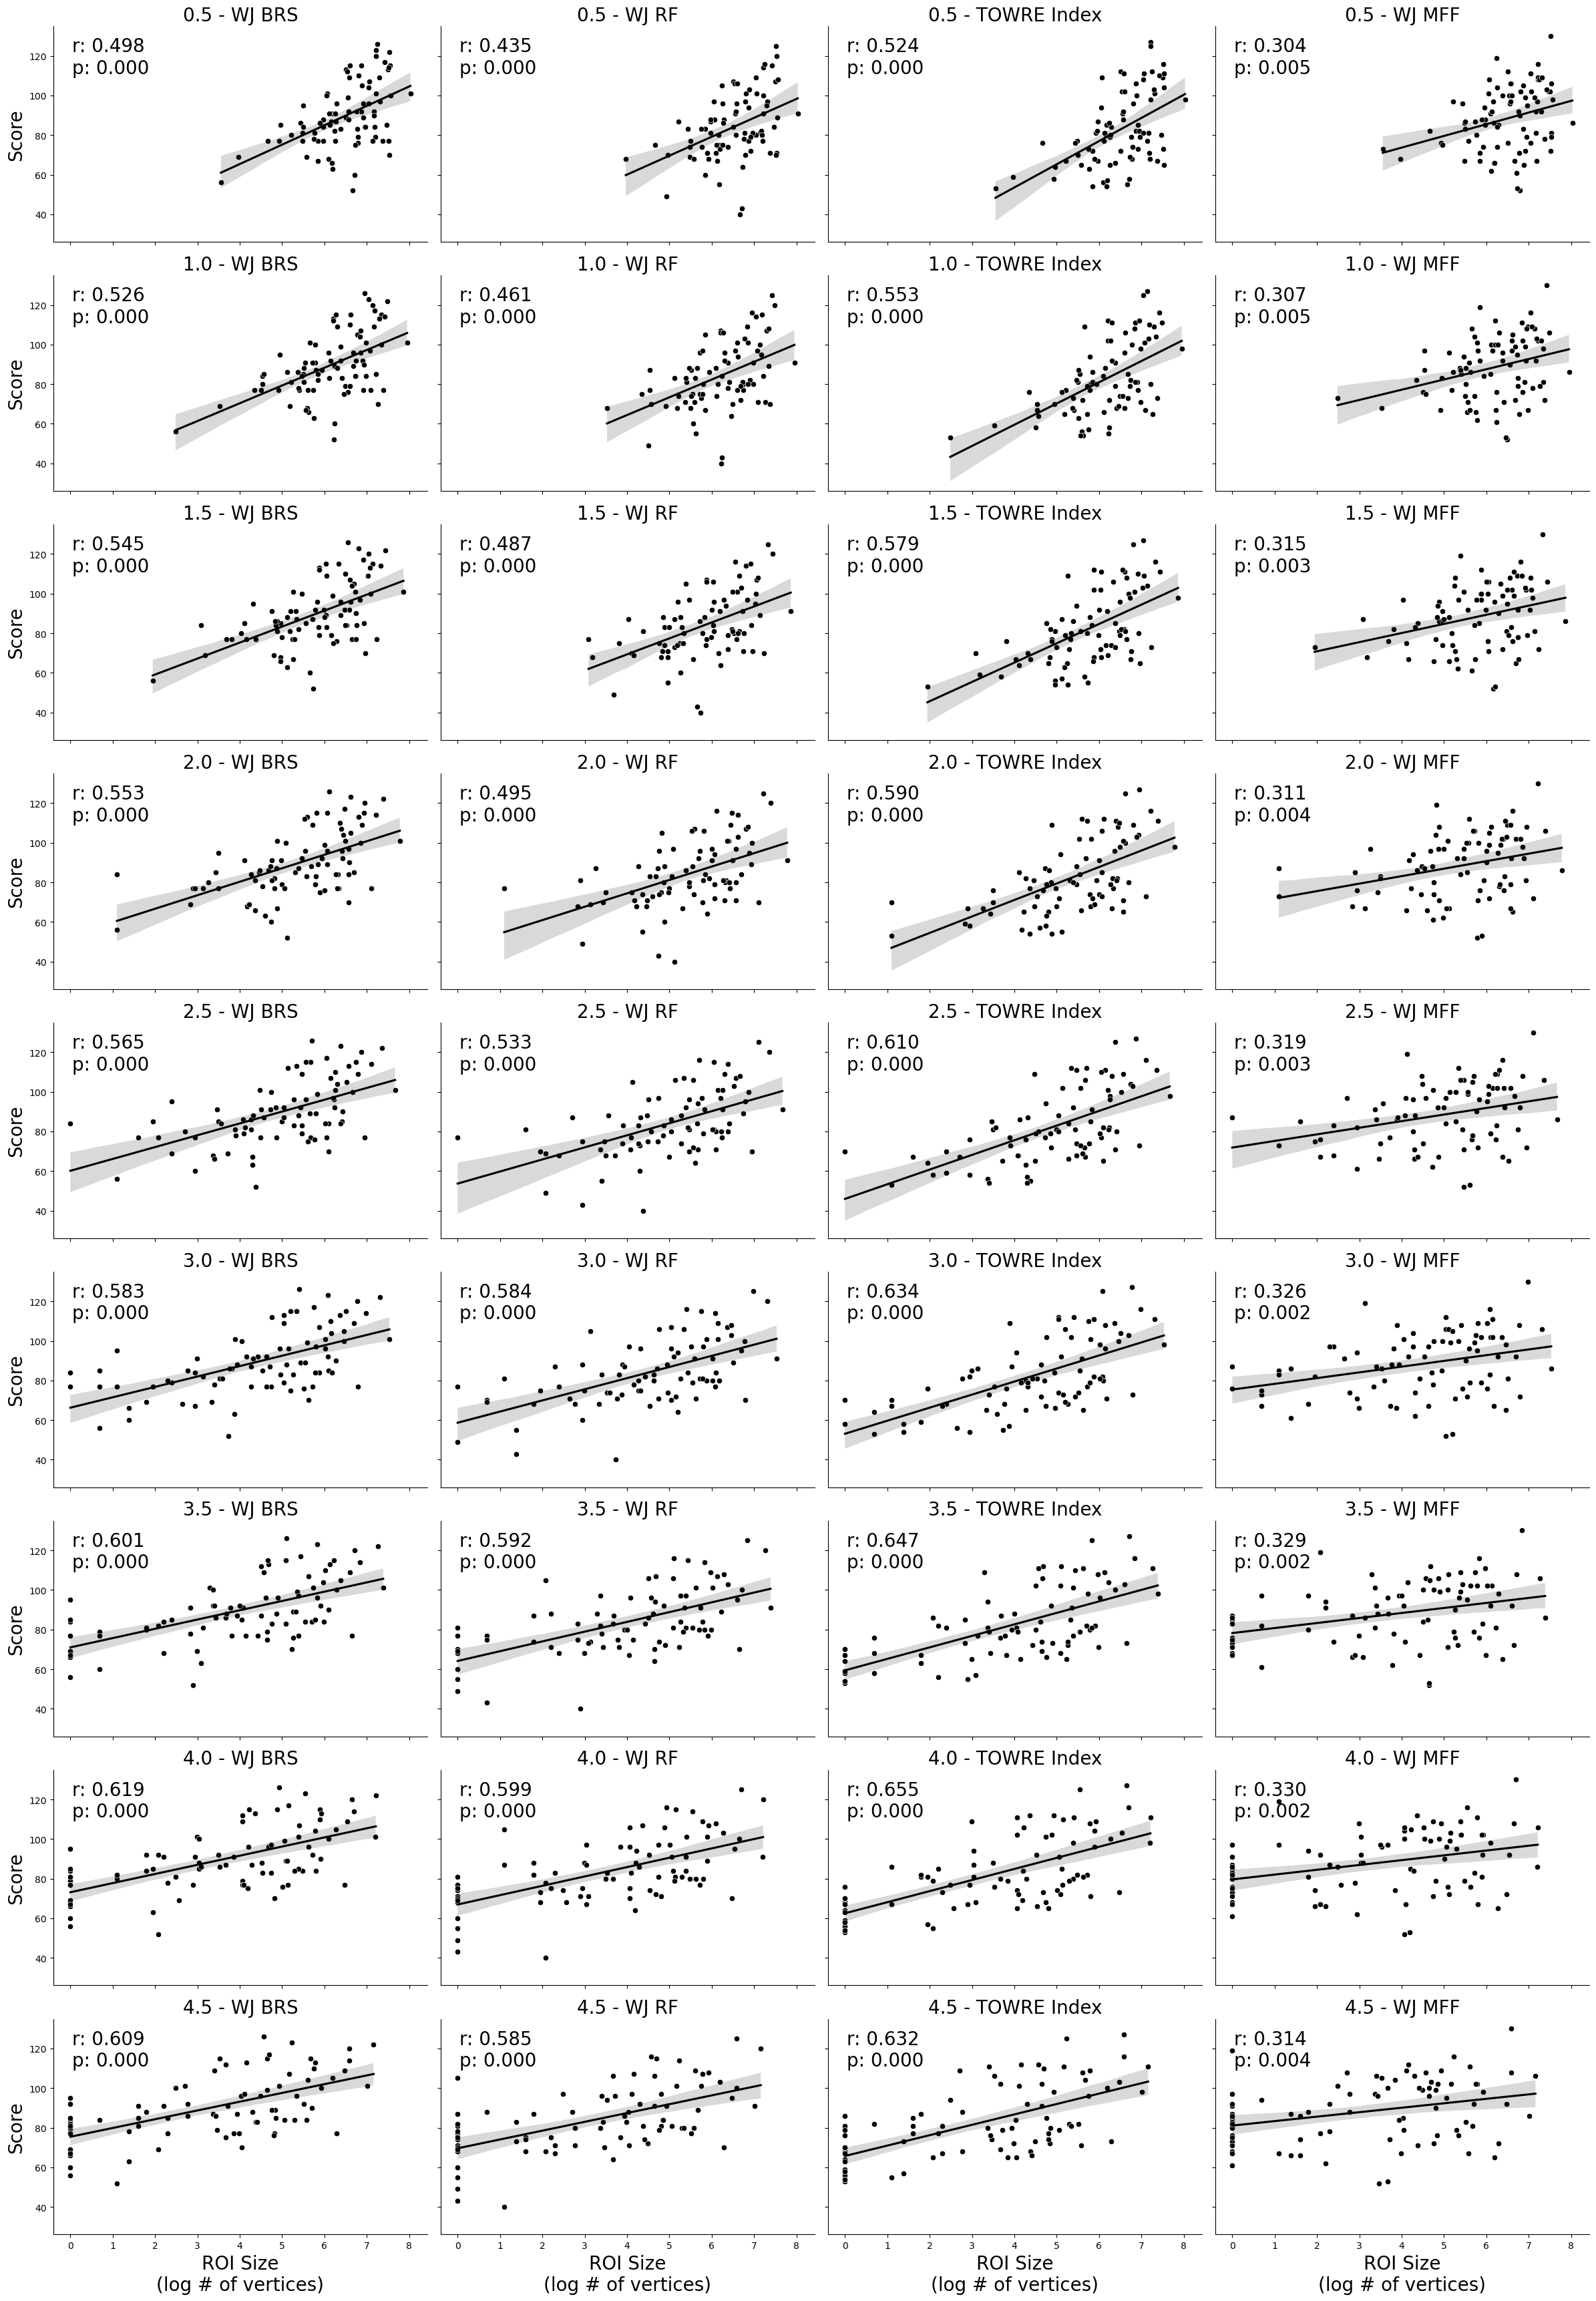

In [7]:
save_fig = False

# load data
data_long =pd.read_csv(f'{data_dir}fig_s3.csv')

# Create variabls for ordering
assessments = ['wj_brs', 'wj_rf', 'twre_index','wj_mff_ss']
thresholds = np.unique(data_long['threshold'])

# Create a FacetGrid
g = sns.FacetGrid(data_long, row='threshold', col='assessment', height=4, aspect=1.5, )

# Map the scatterplot and regplot onto the FacetGrid
g.map(sns.scatterplot, 'log_size', 'score', color='black')
g.map(sns.regplot, 'log_size', 'score', scatter=False, color='black')

# Apply the annotation function to each subplot
g.map_dataframe(uf.annotate_regression_corr,x_param='log_size',y_param='score')

# Set uniform x and y-axis labels
g.set_axis_labels('ROI Size\n(log # of vertices)', 'Score', size=20)

# Set titles and labels for each subplot
for i, threshold in enumerate(thresholds):
    for j, assessment in enumerate(assessments):
        ax = g.axes[i, j]
        ax.set_title(f'{threshold} - {titles[assessment]}', size=20)

# Adjust layout to ensure labels are visible
plt.tight_layout(rect=[0, 0, 1, 0.96])

if save_fig:
    plt.savefig(f'{fig_dir}fig_s3.svg', bbox_inches="tight",transparent=True, dpi=400)

plt.show()
